<a href="https://colab.research.google.com/github/rubusarbaro/supplychain-forecast-FIME/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##############################################################################
###                           Modelo Prophet                                ##
###                        S&OP                                             ##
###                     20/02/2024                                          ##
###                                                   xoce15@ingenieros.com ##
##############################################################################

# Instalación de librarias

In [ ]:
!pip install --q prophet
!pip install  --q fix-yahoo-finance==0.1.30
!pip install --q yfinance

# Librerias

In [ ]:
from google.colab import drive, auth
import os
import pandas as pd
import pandas_gbq
import numpy as np
import datetime
import re
import os.path, time
from google.colab import files
import pytz
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet
from pandas import to_datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import yfinance as yf

# Que es Prophet

$y_{t}= g_{t}+s_{t}+h_{t}+ e_{t} $

*   $y_{t}$ : Variable a predecir
*   $g_{t}$ : Función de tendencia
*   $s_{t}$ : Cambios periódicos
*   $h_{t}$ : Efectos de vacaciones (eventos atípicos)
*   $e_{t}$ : Error

# Funciones

In [ ]:
def seasonality_check():

    # model seasonalities
    # wy

    # default values
    day = False
    week = True
    month = True
    year = True

    # Siempre es de 2 años el periodo...
    # # check how many periods are inside df
    # periods = \
    # min(
    #     # size by diff
    #     # Max - Min day in dataframe
    #     (max(bq_df['ds']) - min(bq_df['ds'])).days
    #     ,
    #     # size by shape
    #     # Number of periods inside dataframe (days)
    #     bq_df.shape[0]
    #     )
    periods = 720

    # remove seasonality if df have less than 90
    if periods < 90:
        month = False

    # remove seasonality if df have less than 365
    if periods <= 365:
        year = False

    # dict with the boolean values
    d = {'day': day, 'week': week, 'month': month, 'year': year}

    return d

In [ ]:
def grafica_plt(df, column_time,colum_value,title='vacio'):
    import plotly.express as px
    fig = px.line(df, x=column_time, y=colum_value,title=title)

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    return fig.show()

# Parametros Prophet

In [ ]:
dict_seasonality = seasonality_check()

parameters = {
        'growth' : 'linear'
        # Si fuera 'logistic' hay qye agregar el 'cap'
        , 'changepoint_range' :0.60
        , 'interval_width' : 0.60
        , 'daily_seasonality' : dict_seasonality['day']   # depende de la cantidad de datos
        , 'weekly_seasonality' : dict_seasonality['week'] # depende de la cantidad de datos
        , 'yearly_seasonality' : dict_seasonality['month'] # depende de la cantidad de datos
        #, 'holidays': get_holidays() # dataframe con los holidays
        , 'seasonality_mode': 'multiplicative'
        , 'seasonality_prior_scale': 1
        , 'holidays_prior_scale': 1
        , 'changepoint_prior_scale': 1
        }

#Descargar datos

Dandole click al siguiente link pueden descargar los [datos](https://finance.yahoo.com/quote/NFLX/history?p=NFLX&guccounter=1&guce_referrer=aHR0cHM6Ly9tZWRpdW0uY29tL29uZXBhZ2Vjb2RlL21hY2hpbmUtbGVhcm5pbmctZm9yLXN0b2NrLXByaWNlLXByZWRpY3Rpb24tNGQwZDJmMGQ1MzUx&guce_referrer_sig=AQAAADa9TcRFKi7N7TM99_ayOuTLMzOKVyzTiZuWBJP3YdKis61oFvcD8FyZr1ilJxWs2vYDN2VkrrmFiM2qZaPA9YACedjHe6oOk4jWzLyudjThi8aeERFuAXez-3bYB_qEkze6Z0oP-Qjp5nwmj7fC1vCW3XhCs8EB1-vVlx80fO9q).



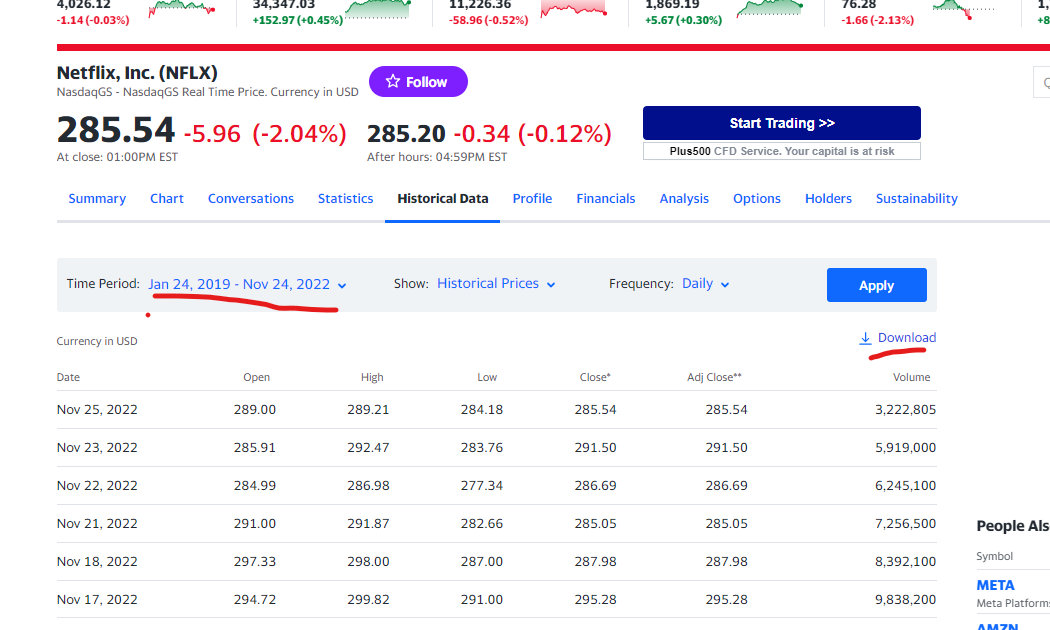


# Cargar datos

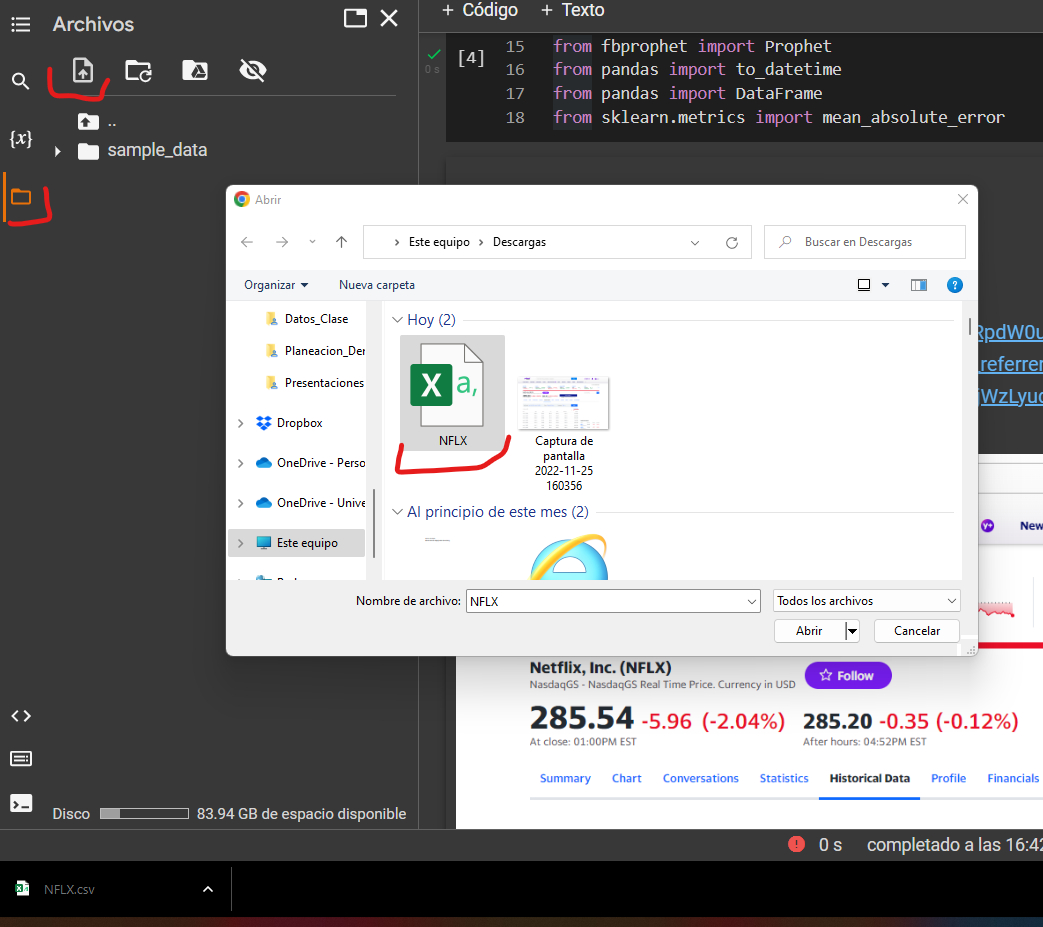

In [ ]:
#empresa_accion= 'NFLX'

today = datetime.datetime.now().strftime('%Y-%m-%d')
start = "2022-12-20"
end = today

column_time='Fecha'
colum_value='Actl'
titles= 'Envios'
titles2= 'Envios reales y Prophet'


column_time2='ds'
colum_value2= 'yhat'

column_time='Fecha'
colum_value='Actl'

Y si tipico no se quiere hacer mayor esfuerzo en la carga de datos, ¿Qué podemos hacer?

Usando la Api de Yahoo finanzas se puede obtener los datos financieros de la empresa que se quiere en el rango de tiempo que se defina.

In [ ]:
# yf.Ticker('TSLA')

# Si quiero obtener la información de las S&P500

#tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
#print(tickers.head())
#data = yf.download(tickers.Symbol.to_list(),start,end, auto_adjust=True)['Close']
#print(data.head())

In [ ]:
## Aqui tenemos la información en la variable yahoo
### y con la sentencia de history vemos las fluctuaciones de está acción

yahoo= yf.Ticker(empresa_accion)


print(yahoo.history(start=start, end=end))

In [ ]:
#df = yf.download(empresa_accion, start=start, end=end,group_by="ticker")
#df.reset_index(inplace=True)
#df.columns = ['Fecha','Actl']

#df[[column_time,colum_value ]].head(2)

#print("----------------------------")
#df[column_time].min() , df[column_time].max()

In [ ]:
# Si queremos hacer la carga de datos manual
df= pd.read_csv("Air.csv")
df.head(2)



,Fecha,Actl
0,2022-12-20,452184
1,2022-12-21,399479


In [ ]:
#today = datetime.datetime.now().strftime('%Y-%m-%d')
#start = "2023-01-01"
#end = today

#column_time='Fecha'
#colum_value='Actl'
#titles= 'Envios'
#titles2= 'Envios reales y Prophet'


#column_time2='ds'
#colum_value2= 'yhat'

#column_time='Date'
#colum_value='Volume'

In [ ]:
df.head(2)

,Fecha,Actl
0,2022-12-20,452184
1,2022-12-21,399479


In [ ]:
column_time

'Fecha'

In [ ]:
df[column_time].min()

'2022-12-20'

In [ ]:
grafica_plt(df, column_time,colum_value,title=titles)

# Creación de dias especiales

A Prophet se le puede especificar que dias son de descanso/asueto y que dias han tenido un evento comercial especifico que muy posiblemente se repetira en el siguiente ciclo.

In [ ]:
def get_holidays():

    """ add holidays to improve performance """

    import pandas as pd

    def dt_serie(start_dt, days):

        """ create a sequence of days """

        from datetime import datetime, timedelta

        first_value = datetime.fromisoformat(start_dt)

        return [(first_value + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(days)]

    # flat list of lists
    def flatten(t):
        return [item for sublist in t for item in sublist]


    # dict of holidays
    d_holiday = {
    'hot sale': {
        'ds': {
            2018: dt_serie('2018-05-28', 5)
            , 2019: dt_serie('2019-05-27', 5)
            , 2020: dt_serie('2020-05-22', 11)
            , 2021: dt_serie('2021-05-23', 10)
            , 2022: dt_serie('2022-05-22', 10)
            , 2023: dt_serie('2023-05-29',8)
            , 2024: dt_serie('2024-05-15',9)
            }
        , 'lower_window' : 0
        , 'upper_window' : 0
        }

    , 'prime day': {
        'ds': {
            2018: dt_serie('2018-07-16', 2)
            , 2019: dt_serie('2019-07-15', 2)
            , 2020: dt_serie('2020-10-13', 2)
            , 2021: dt_serie('2021-06-14', 2)
            , 2022: dt_serie('2022-07-11', 2)
            , 2023: dt_serie('2023-07-11',2)
            , 2024: dt_serie('2024-07-12',2)
            }
        , 'lower_window' : 0
        , 'upper_window' : 0
        }

    , 'buen fin': {
        'ds': {
              2018: dt_serie('2018-11-16', 4)
            , 2019: dt_serie('2019-11-15', 4)
            , 2020: dt_serie('2020-11-09', 12)
            , 2021: dt_serie('2021-11-10', 7)
            , 2022: dt_serie('2022-11-18', 4)
            , 2023: dt_serie('2023-11-17',4)
            , 2024: dt_serie('2024-11-15',4)
            }
        , 'lower_window' : 0
        , 'upper_window' : 1
        }

    , 'black friday': {
        'ds': {
            2019: dt_serie('2019-11-29', 4)
            , 2020: dt_serie('2020-11-27', 4)
            , 2021: dt_serie('2021-11-26', 7)
            , 2022: dt_serie('2022-11-25', 4)
            , 2023: dt_serie('2023-11-25', 4)
            , 2024: dt_serie('2024-11-29',4)
            }
        , 'lower_window' : 0
        , 'upper_window' : 0
        }
  }

    l_empty = []
    for i in d_holiday:

        # flat list of lists of holiday dates
        ds = flatten([d_holiday[i]['ds'][j] for j in d_holiday[i]['ds']])

        l_empty.append(
            pd.DataFrame({
                'holiday' : i
                , 'ds' : pd.to_datetime(ds)
                , 'lower_window' : d_holiday[i]['lower_window']
                , 'upper_window' : d_holiday[i]['upper_window']})
            )
    # get country holidays
    from prophet.make_holidays import make_holidays_df
    country_years = list(set(flatten([[j for j in d_holiday[i]['ds']] for i in d_holiday])))
    country_holidays = make_holidays_df(year_list = country_years, country='MX')
    country_holidays['lower_window'] = -1
    country_holidays['upper_window'] = 1
    l_empty.append(country_holidays)

    # return all holidays
    return pd.concat(l_empty, ignore_index=True)

# Entrenamiento del modelo

Para obtener pronósticos de una serie temporal, se necesita proporcionar a Prophet un nuevo DataFrame que contenga una columna ds con las fechas para las que se quiere hacer las predicciones.

Convenientemente, no se tiene que preocupar por crear manualmente este DataFrame, ya que Prophet proporciona la función auxiliar make_future_dataframe (Linea 11 de la siguiente celda).



**Nota:**
Cuidado Prophet espera dos columnas
**'ds'** y **'y'** si no las tiene asi se recomienda reetiquetarlas.

In [ ]:
today = datetime.datetime.now()
past_date= [(today - datetime.timedelta(days= i)).strftime('%Y-%m-%d') for i in range(15) ]

data1=df[[column_time,colum_value ]]
data1.columns=['ds','y']


my_model = Prophet(**parameters)
my_model.fit(data1)

future_dates = my_model.make_future_dataframe(periods=120, freq='d')
forecast = my_model.predict(future_dates)

#forecast_mape = my_model.predict(past_date)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz7l07nd2/23trd_20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz7l07nd2/3yl5mhv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99403', 'data', 'file=/tmp/tmpz7l07nd2/23trd_20.json', 'init=/tmp/tmpz7l07nd2/3yl5mhv_.json', 'output', 'file=/tmp/tmpz7l07nd2/prophet_modelocb564na/prophet_model-20240228012048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


En el fragmento de código anterior, se le indico a Prophet que genere 120  marcas de fecha en el futuro.
Al trabajar con Prophet, es importante tener en cuenta la frecuencia de la serie temporal.

Debido a que se está trabajando con datos diarios, se especifica  claramente la frecuencia deseada de las marcas de tiempo (en este caso, **'d'** ).

Por lo tanto, make_future_dataframe generó **120** marcas de tiempo diarias.

El DataFrame de fechas futuras se usa luego como entrada para el método de predicción del modelo ajustado.


Prophet devuelve un DataFrame grande con muchas columnas interesantes, pero se puede dividir la salida en las columnas más relevantes para la previsión.
Estos son:



*   **ds:** la marca de fecha del valor pronosticado
*   **yhat:** el valor pronosticado (en Estadística, yhat es una notación utilizada tradicionalmente para representar los valores pronosticados de un valor y)
*   **yhat_lower**: el límite inferior de nuestros pronósticos
*   **yhat_upper**: el límite superior de nuestros pronósticos









# Grafica de la predicción vs el real

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

#grafica_plt(forecast, column_time2,colum_value2,title='Nexflix_prophet')


fig.add_trace(go.Scatter(x=forecast[column_time2], y=forecast[colum_value2], name='Prophet',
                            line = dict(color='#8C000F', width=3, dash='dash')))

fig.add_trace(go.Scatter(x=df[column_time], y=df[colum_value], name='reales',
                            line = dict(color='olive', width=3, dash='dash')))
fig.update_layout(title= titles2, xaxis_title="Dia de la semana",yaxis_title="Valor de la acción")

Si se quiere ver los intervalos de confianza

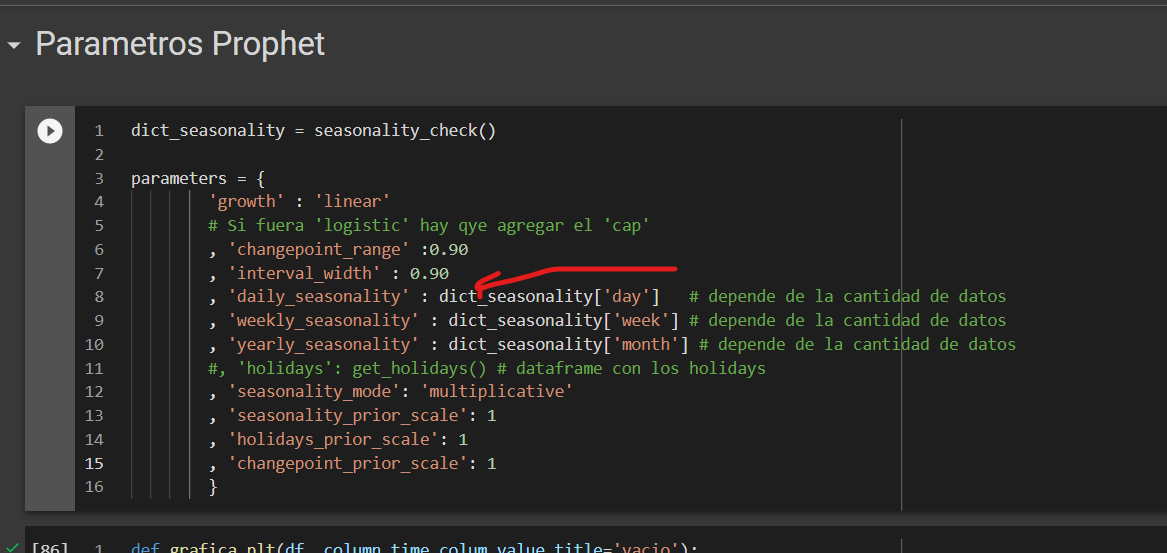

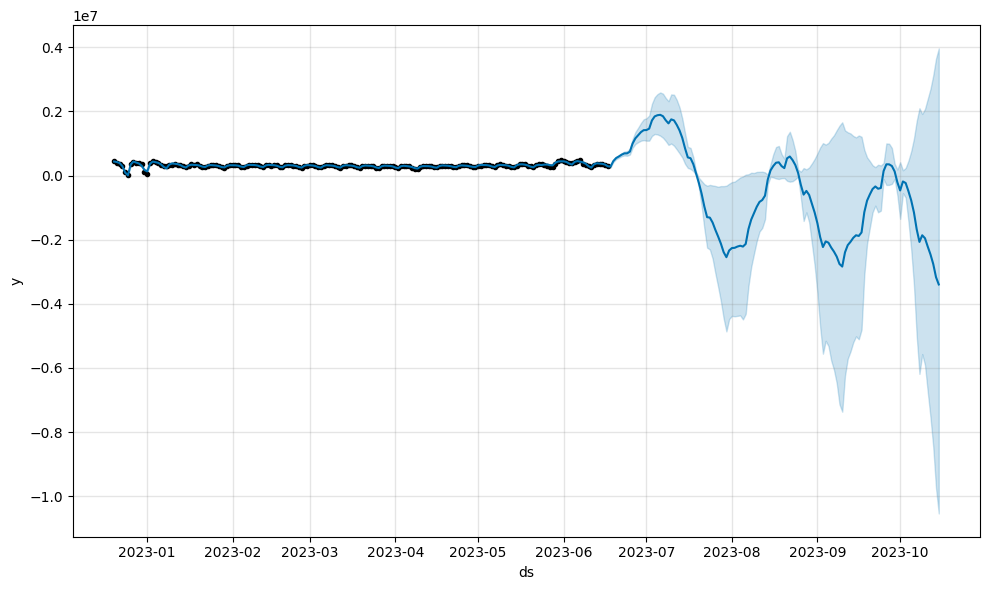

In [ ]:
my_model.plot(forecast)
plt.show()

In [ ]:
#my_model.plot(forecast)


from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(my_model, forecast)

Una característica particularmente fuerte de Prophet es su capacidad para devolver los componentes de los pronósticos.

Esto puede ayudar a revelar cómo los patrones diarios, semanales y anuales de la serie temporal contribuyen a los valores pronosticados generales.

# Componentes

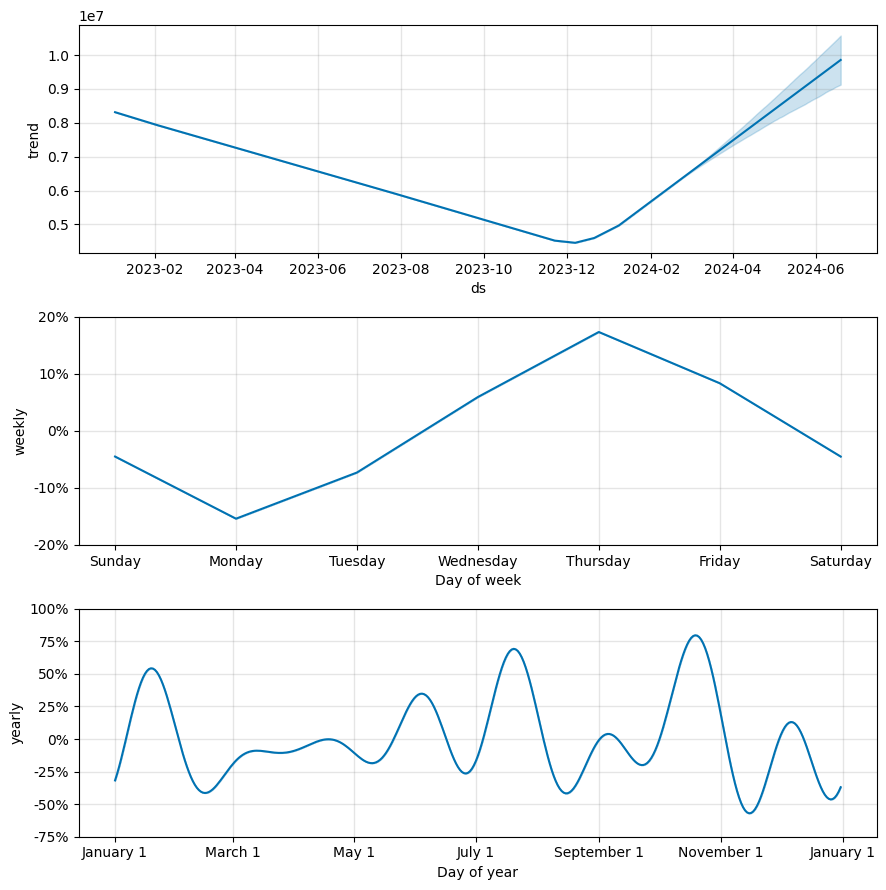

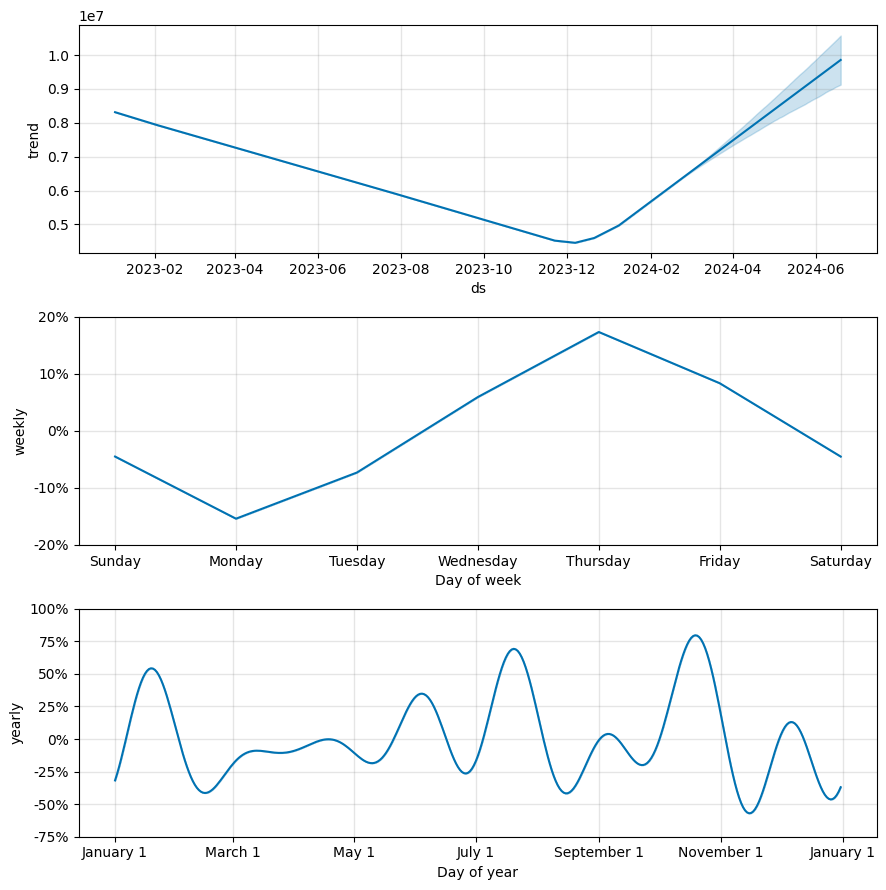

In [ ]:
my_model.plot_components(forecast)

El diagrama anterior proporciona ideas interesantes.

El primer gráfico muestra que el volumen diario de las acciones ha aumentado linealmente con el tiempo.

El segundo gráfico destaca el hecho de que el valor de las acciones llega a su maximo los miercoles. Perdiendo valor los fines de semana.

El tercer gráfico muestra que la mayor parte del valor de las acciones se  produce durante los meses mayo y enero.

# Agregar punto de cambios a Prophet

Los puntos de cambio son los puntos de fecha y hora en los que la serie temporal tiene cambios abruptos en la trayectoria.

Por defecto, Prophet agrega 25 puntos de cambio al 80% inicial del conjunto de datos.

Se traza las líneas verticales donde ocurrieron los posibles puntos de cambio.

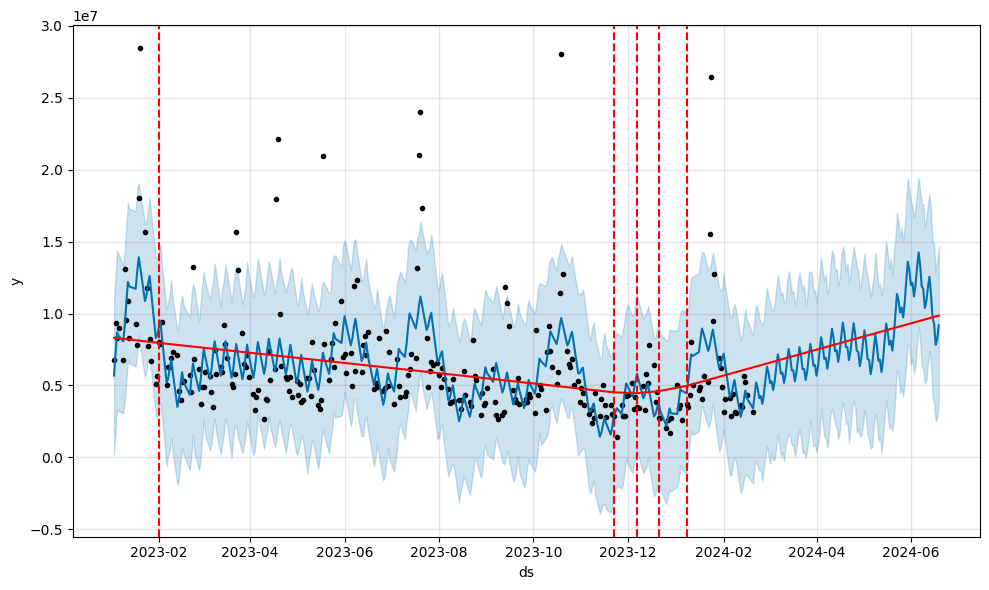

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

Podemos ver las fechas en las que ocurrieron los puntos de cambio.

In [ ]:
my_model.changepoints

10    2023-01-18
20    2023-02-01
30    2023-02-15
41    2023-03-03
51    2023-03-17
61    2023-03-31
71    2023-04-17
81    2023-05-01
91    2023-05-15
102   2023-05-31
112   2023-06-14
122   2023-06-29
132   2023-07-14
142   2023-07-28
152   2023-08-11
163   2023-08-28
173   2023-09-12
183   2023-09-26
193   2023-10-10
203   2023-10-24
213   2023-11-07
224   2023-11-22
234   2023-12-07
244   2023-12-21
254   2024-01-08
Name: ds, dtype: datetime64[ns]

Se puede cambiar el rango de puntos de cambio inferido configurando changepoint_range.



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyupshel8/zmhfwb1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyupshel8/aimryfky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72600', 'data', 'file=/tmp/tmpyupshel8/zmhfwb1t.json', 'init=/tmp/tmpyupshel8/aimryfky.json', 'output', 'file=/tmp/tmpyupshel8/prophet_modelasspxgg6/prophet_model-20240221013727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


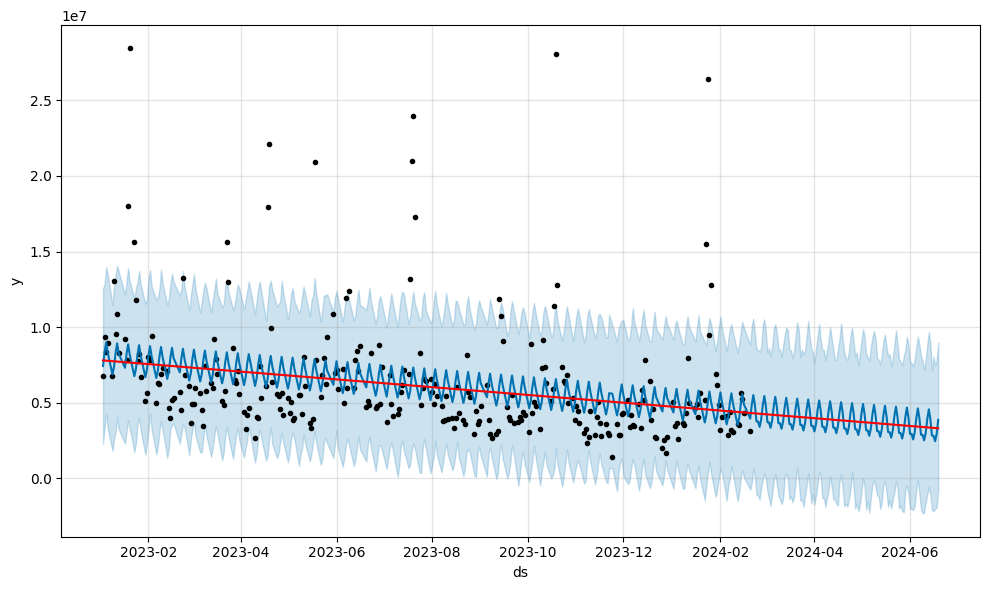

In [ ]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(data1).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

El número de puntos de cambio se puede configurar usando el parámetro n_changepoints al inicializar el Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyupshel8/dd2ncfj_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyupshel8/39dgc4fc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90615', 'data', 'file=/tmp/tmpyupshel8/dd2ncfj_.json', 'init=/tmp/tmpyupshel8/39dgc4fc.json', 'output', 'file=/tmp/tmpyupshel8/prophet_modelazmqo1vj/prophet_model-20240221013731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


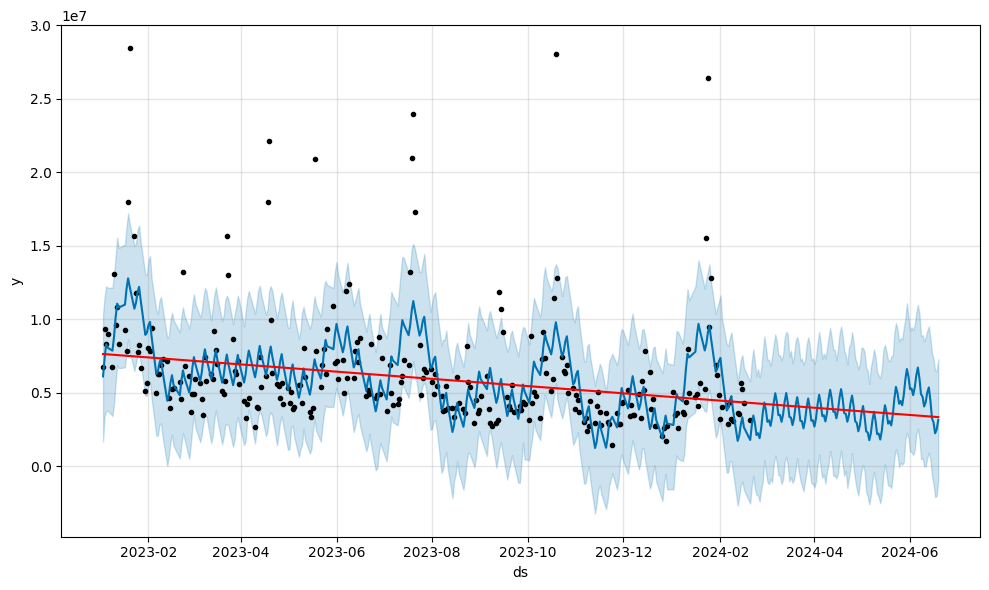

In [ ]:
pro_change= Prophet(n_changepoints=5, yearly_seasonality=True)
forecast = pro_change.fit(data1).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

# Ajuste de Tendencia

Prophet nos permite ajustar la tendencia en caso de que haya un overfit o underfit.

changepoint_prior_scale ayuda a ajustar la fuerza de la tendencia.

El valor predeterminado para changepoint_prior_scale es 0,05.

Disminuya el valor para que la tendencia sea menos flexible.

Aumente el valor de changepoint_prior_scale para que la tendencia sea más flexible.

Aumentar changepoint_prior_scale a 0,08 para que la tendencia sea flexible.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyupshel8/tj93xvn1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyupshel8/9uaayg39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62003', 'data', 'file=/tmp/tmpyupshel8/tj93xvn1.json', 'init=/tmp/tmpyupshel8/9uaayg39.json', 'output', 'file=/tmp/tmpyupshel8/prophet_modeljffuv_oc/prophet_model-20240221013736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


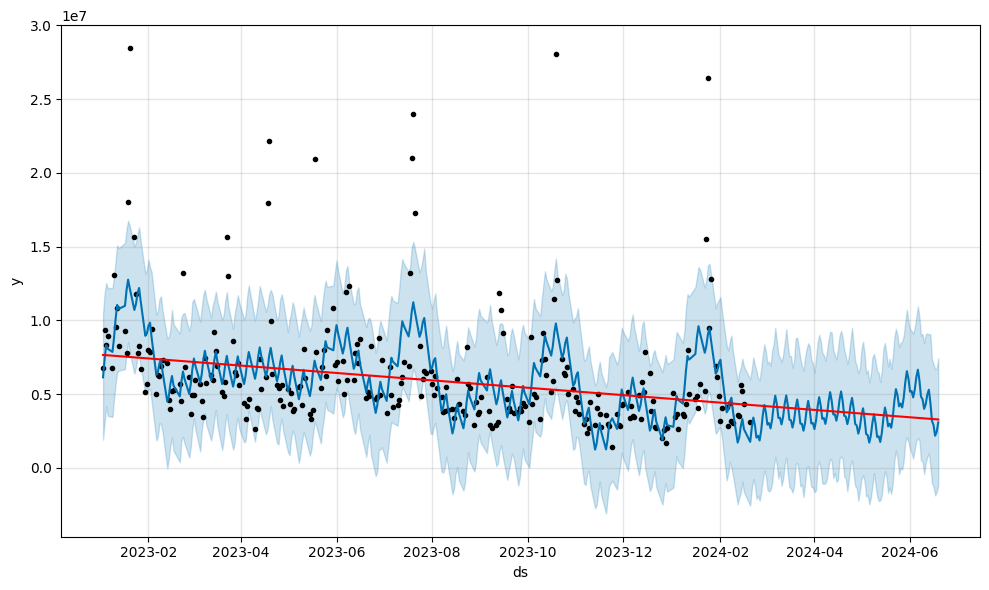

In [ ]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(data1).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyupshel8/nxksvjrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyupshel8/hr5s8mh9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41284', 'data', 'file=/tmp/tmpyupshel8/nxksvjrx.json', 'init=/tmp/tmpyupshel8/hr5s8mh9.json', 'output', 'file=/tmp/tmpyupshel8/prophet_model80vwa1u2/prophet_model-20240221013741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


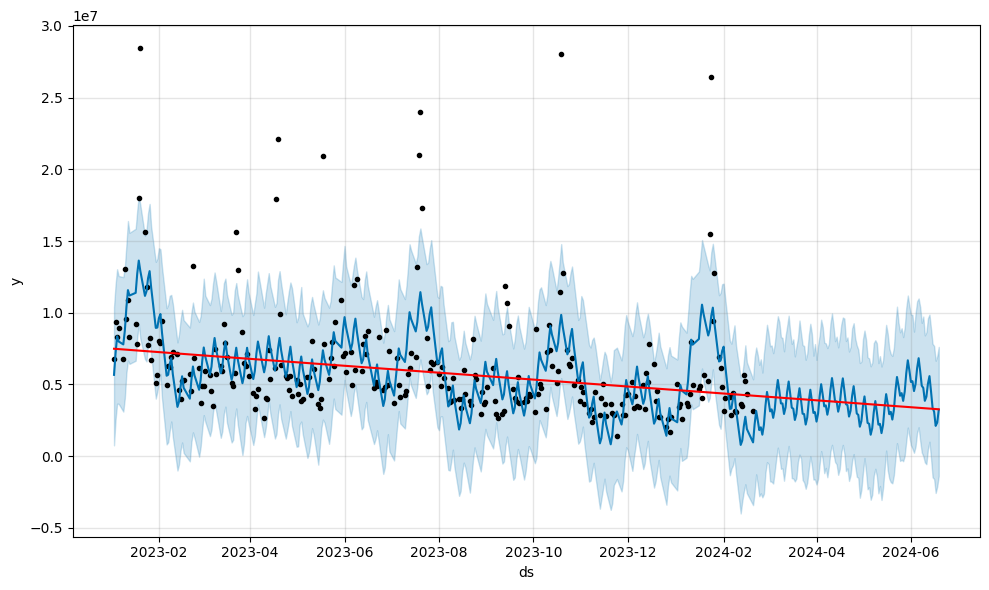

In [ ]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(data1).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

# Descargar datos de Google colab

In [ ]:
from google.colab import files
import pandas as pd

forecast.to_csv('example_file.csv')
files.download('example_file.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>